# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.475207,False,-1.637703
1,-1.306290,False,-0.592534
2,-0.254745,True,5.202848
3,-1.765457,False,-0.729855
4,-1.217787,False,1.744981
...,...,...,...
995,-1.564678,False,-2.430011
996,0.104382,False,-1.665688
997,-1.203350,False,-0.676596
998,-0.224327,True,2.807310


<Axes: xlabel='v0'>

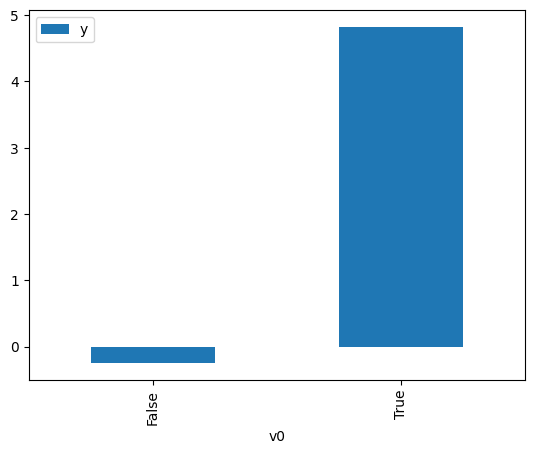

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

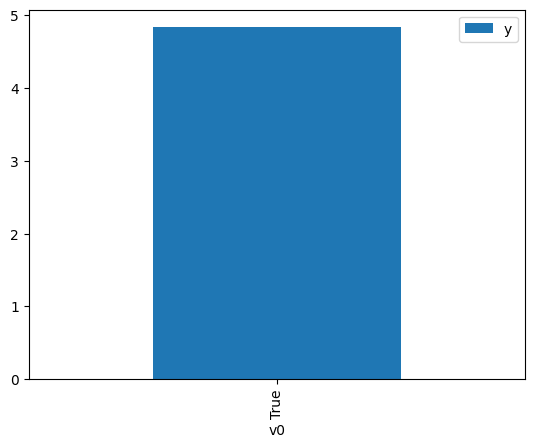

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.945059,False,-0.714794,0.909477,1.099533
1,-1.107434,False,-0.230965,0.937391,1.066790
2,-2.831183,False,2.358793,0.999034,1.000967
3,-1.226941,False,-0.790299,0.952566,1.049796
4,-0.360534,False,-0.609336,0.704984,1.418472
...,...,...,...,...,...
995,-0.987569,False,0.755833,0.917716,1.089662
996,-1.065963,False,-1.821388,0.931138,1.073954
997,-0.642963,False,0.721979,0.827076,1.209079
998,-1.729997,False,-0.416009,0.985738,1.014469


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.683963,True,5.336813,0.158988,6.289779
1,-1.177180,True,5.724969,0.053274,18.770826
2,0.619508,True,5.629093,0.822986,1.215087
3,-1.779504,True,5.000773,0.012650,79.054261
4,-1.779504,True,5.000773,0.012650,79.054261
...,...,...,...,...,...
995,-1.295123,True,4.198375,0.040414,24.744010
996,-0.254745,True,5.202848,0.351778,2.842703
997,-1.045733,True,6.100714,0.072118,13.866250
998,-1.779504,True,5.000773,0.012650,79.054261


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.870
Model:                            OLS   Adj. R-squared (uncentered):              0.870
Method:                 Least Squares   F-statistic:                              3345.
Date:                Tue, 29 Oct 2024   Prob (F-statistic):                        0.00
Time:                        15:11:41   Log-Likelihood:                         -1396.5
No. Observations:                1000   AIC:                                      2797.
Df Residuals:                     998   BIC:                                      2807.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2118      0.024      8.950      0.000       0.165       0.258
x2             4.9496      0.062     80.334      0.000       4.829       5.070
==============================================================================
Omnibus:                        4.667   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.097   Jarque-Bera (JB):                5.034
Skew:                          -0.092   Prob(JB):                       0.0807
Kurtosis:                       3.295   Cond. No.                         2.62
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""